In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
# Might not need
import matplotlib.tri as mtri


# **Import Data/Preprocessing**

In [25]:
# Might need to run if not connected to the google drive

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [26]:
path="/gdrive/MyDrive/Colab Notebooks/Reseach Spring 2023/rough-sfd-ml/roughsims/07-Jun-2019_Run1, Seed_19/Results/"


Plan to run through different data roughness experiement

In [27]:
# text_data = []
# directory = '/path/to/your/text/files'

# for filename in os.listdir(directory):
#     if filename.endswith('.txt'):
#         filepath = os.path.join(directory, filename)
#         with open(filepath, 'r', encoding='utf-8') as file:
#             text_data.append(file.read())

In [28]:
# # # Domain Parameters
# # a_data = np.loadtxt(path+'a.txt')  # 'a' might represent the length of the domain in the lubrication problem.



# # Load the text file, specify the delimiter if it's not a comma
# df = pd.read_csv(path+'a.txt', sep=',')

# # Display the first few rows of the DataFrame
# print(df.head())

Open up one roughness experiement

In [29]:


# Domain Parameters
# If 'a.txt' contains a single value or structured data, adjust the loading method accordingly
a_data = pd.read_csv(path+'a.txt', sep=',', header=None)

# Simulation Parameters
t_data = pd.read_csv(path+'t.txt', sep=',', header=None)
hdot_data = pd.read_csv(path+'hdot.txt', sep=',', header=None)
hdotdot_data = pd.read_csv(path+'hdotdot.txt', sep=',', header=None)

# Mesh Grid Data
TRIANGLES_data = pd.read_csv(path+'TRIANGLES.txt', sep=',', header=None, dtype=int)
X_data = pd.read_csv(path+'X.txt', sep=',', header=None)
Y_data = pd.read_csv(path+'Y.txt', sep=',', header=None)
Z_data = pd.read_csv(path+'Z.txt', sep=',', header=None)
NODES_data = pd.read_csv(path+'NODES.txt', sep=',', header=None)

# Fluid Properties and Initial/Boundary Conditions
h_data = pd.read_csv(path+'h.txt', sep=',', header=None)
Pressure_data = pd.read_csv(path+'Pressure.txt', sep=',', header=None)
Fsd_data = pd.read_csv(path+'Fsd.txt', sep=',', header=None)

# # Assuming you've converted surf.fig to surf.png and placed it in the same directory:
# img = plt.imread(path+'../surf.png')
# plt.imshow(img)
# plt.show()


Might can take this out double check..

In [30]:
# Numpy arrays
t_data_array = t_data.values
Fsd_data_array = Fsd_data.values
Z_data_array = Z_data.values # 51, 51


In [31]:
# Fsd_data_array.size
# Fsd_data_array.shape
# type(Fsd_data_array)

Look at different ways of flattening. We have 51x51 => 2601. We can look at the different ways of going about this. Other than: `.flatten()`

In [32]:
# Flatten the arrays to ensure they are 1-dimensional
t_data_array_flat = t_data_array.flatten() # 601
Fsd_data_array_flat = Fsd_data_array.flatten() # 601
Z_data_array_flat = Z_data_array.flatten() # 2601

# **Plots so see what data we are working with**

Fsd_data/t_data

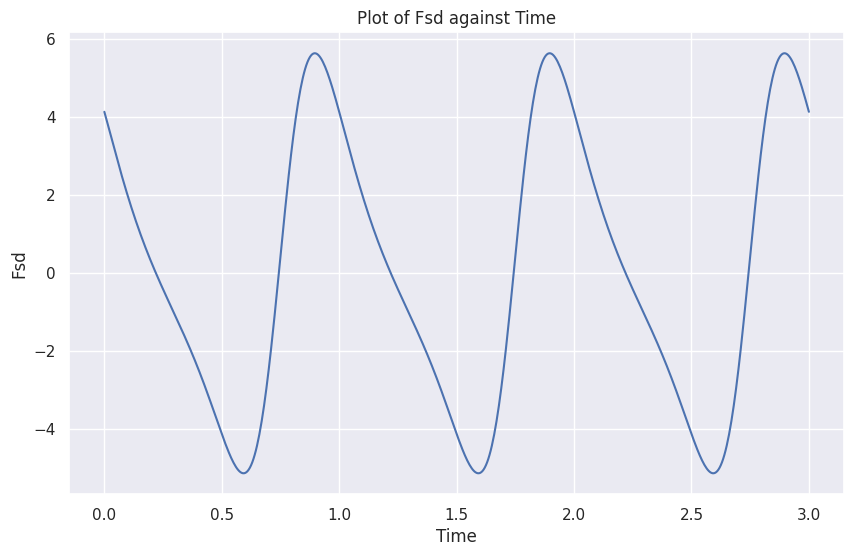

In [33]:
# Create a DataFrame from the 1-dimensional numpy arrays for plotting
data_for_plot = pd.DataFrame({
    'Time': t_data_array_flat,
    'Fsd': Fsd_data_array_flat
})

# Now, use Seaborn to plot the data
sns.set_theme()  # Apply the default theme for nicer aesthetics
plt.figure(figsize=(10, 6))  # Optional: Adjusts the figure size

# Plot using Seaborn's lineplot function
sns.lineplot(x='Time', y='Fsd', data=data_for_plot)

# Adding labels and a title to the plot
plt.xlabel('Time')
plt.ylabel('Fsd')
plt.title('Plot of Fsd against Time')
plt.show()  # Display the plot



Just Fsd_data/NO-Time

Need to scale this to make sure we can look at the different surfaces. Just want to see the differences in them.

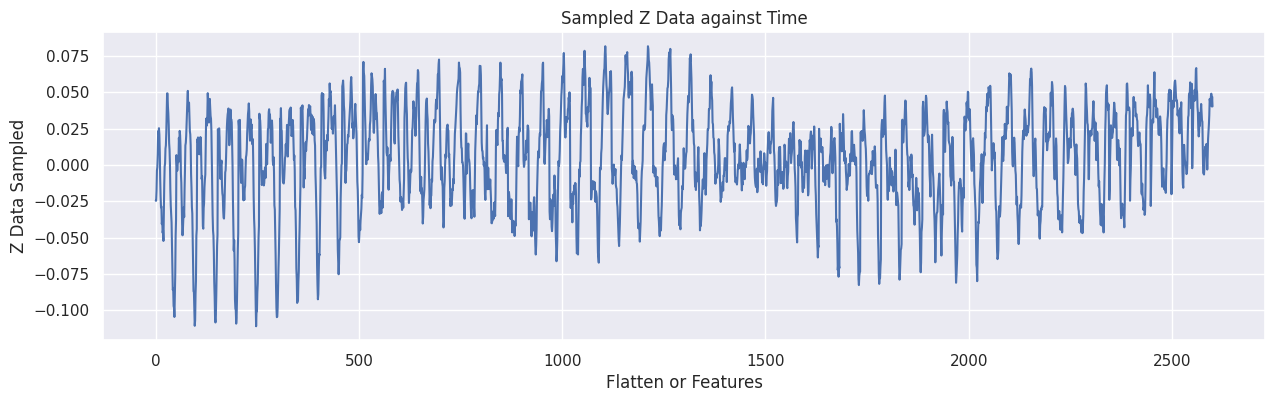

In [34]:
plt.figure(figsize=(15, 4))
plt.plot(Z_data_array_flat)
plt.xlabel('Flatten or Features')
plt.ylabel('Z Data Sampled')
plt.title('Sampled Z Data against Time')
plt.show()

I was advised to add time, but I haven't  figured out se to add time but haven't  figured out to how to combine it.

In [35]:
# t_data_array_flat # 601 needs to go to 2601

Now make 601 copies of Z_data_array_flat

In [36]:
# Make 601 copies of Z_data_array_flat, resulting in a shape of (601, 2601)
Z_data_copied = np.tile(Z_data_array_flat, (601, 1))

# Check the shape of the new array
print(Z_data_copied[:10, :5])

[[-0.024557  -0.024557  -0.017753  -0.0037546 -0.0014016]
 [-0.024557  -0.024557  -0.017753  -0.0037546 -0.0014016]
 [-0.024557  -0.024557  -0.017753  -0.0037546 -0.0014016]
 [-0.024557  -0.024557  -0.017753  -0.0037546 -0.0014016]
 [-0.024557  -0.024557  -0.017753  -0.0037546 -0.0014016]
 [-0.024557  -0.024557  -0.017753  -0.0037546 -0.0014016]
 [-0.024557  -0.024557  -0.017753  -0.0037546 -0.0014016]
 [-0.024557  -0.024557  -0.017753  -0.0037546 -0.0014016]
 [-0.024557  -0.024557  -0.017753  -0.0037546 -0.0014016]
 [-0.024557  -0.024557  -0.017753  -0.0037546 -0.0014016]]


In [37]:
X = Z_data_copied
y = Fsd_data_array_flat

print('shape of x is : ',X.shape)
print('shape of y is : ',y.shape)

shape of x is :  (601, 2601)
shape of y is :  (601,)


# **PyTorch For Deep Learning — Feed Forward Neural Network**

https://machinelearningmastery.com/building-a-regression-model-in-pytorch/


In [38]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing

# # Read data
# data = fetch_california_housing()
# X, y = data.data, data.target

print('shape of x is : ',X.shape)
print('shape of y is : ',y.shape)

shape of x is :  (601, 2601)
shape of y is :  (601,)


In [39]:
# train-test split for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

print('shape of X_train is : ',X_train.shape)
print('shape of X_test is : ',X_test.shape)
print('shape of y_train is : ',y_train.shape)
print('shape of y_test is : ',y_test.shape)

shape of X_train is :  (420, 2601)
shape of X_test is :  (181, 2601)
shape of y_train is :  (420,)
shape of y_test is :  (181,)


In [40]:
# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)


MSE: 11.88
RMSE: 3.45


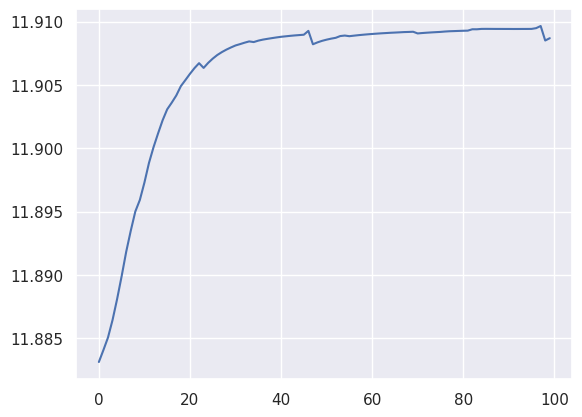

Train MSE: 12.06
Test MSE: 11.88


In [41]:
# Define the model
model = nn.Sequential(
    nn.Linear(2601, 512),  # First layer takes 2601 inputs
    nn.ReLU(),
    nn.Linear(512, 128),  # Subsequent layers reduce the dimension
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1)      # Output layer produces a single output
)


# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()


# Print final results
final_mse_train = float(loss_fn(model(X_train), y_train))
final_mse_test = float(loss_fn(model(X_test), y_test))

print("Train MSE: %.2f" % final_mse_train)
print("Test MSE: %.2f" % final_mse_test)

# **RandomForestClassifier**

1.11.2. Random forests and other randomized tree ensembles: [link text](https://scikit-learn.org/stable/modules/ensemble.html#)

In [42]:
# # Fix
# from sklearn.ensemble import RandomForestClassifier
# X = [[0, 0], [1, 1]]
# Y = [0, 1]
# clf = RandomForestClassifier(n_estimators=10)
# clf = clf.fit(X, Y)

https://www.geeksforgeeks.org/random-forest-regression-in-python/

In [43]:
x = Z_data_copied
y = Fsd_data_array_flat

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 45)

print('shape of X_train is : ',X_train.shape)
print('shape of X_test is : ',X_test.shape)
print('shape of y_train is : ',y_train.shape)
print('shape of y_test is : ',y_test.shape)

shape of X_train is :  (420, 2601)
shape of X_test is :  (181, 2601)
shape of y_train is :  (420,)
shape of y_test is :  (181,)


In [45]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error

# Define models in a dictionary
models = {
    "RandomForestRegressor": RandomForestRegressor(),
    "XGBRegressor": xgb.XGBRegressor(objective ='reg:squarederror', n_estimators=1000, learning_rate=0.1, max_depth=5, alpha=10)
}

# Fit models
for model_name, model in models.items():
    model.fit(X_train, y_train)

# Predict and calculate MSE
mse_scores = {}
for model_name, model in models.items():
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    mse_scores[model_name] = {"Train MSE": mse_train, "Test MSE": mse_test}

# Print MSE scores
for model_name, scores in mse_scores.items():
    print(f"{model_name} - Train MSE: {scores['Train MSE']:.2f}, Test MSE: {scores['Test MSE']:.2f}")


RandomForestRegressor - Train MSE: 11.81, Test MSE: 12.44
XGBRegressor - Train MSE: 11.81, Test MSE: 12.44


In [ ]:
# Creating an array from 1 to 2601 and converting it to a string
array_1_to_2601 = list(range(1, 2602))
array_1_to_2601_str = [str(i) for i in array_1_to_2601]

# Joining the string representation of the array into a single string
string_of_1_to_2601 = ",".join(array_1_to_2601_str)
string_of_1_to_2601

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import matplotlib.pyplot as plt

# Initialize models
random_forest_regressor = RandomForestRegressor()
xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5, alpha=10)

# Assuming X_train is a DataFrame and you have feature names:
feature_names = string_of_1_to_2601

# List of models for iteration
models = [
    ("RandomForestRegressor", random_forest_regressor),
    ("XGBRegressor", xgb_regressor)
]

for name, model in models:
    # Fit model
    model.fit(X_train, y_train)

    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculate MSE
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    # Print MSE
    print(f"{name} - Train MSE: {mse_train:.2f}, Test MSE: {mse_test:.2f}")

    # Feature importance for RandomForestRegressor
    if name == "RandomForestRegressor":
        mdi_importances = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=True)
        ax = mdi_importances.plot.barh(figsize=(10, 6))
        ax.set_title(f"{name} Feature Importances (MDI)")
        ax.figure.tight_layout()
        plt.show()

    # For XGBRegressor, similar approach can be used if you wish to plot feature importances
    elif name == "XGBRegressor":
        # This assumes XGBRegressor's feature_importances_ can be directly related to feature names
        mdi_importances = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=True)
        ax = mdi_importances.plot.barh(figsize=(10, 6))
        ax.set_title(f"{name} Feature Importances")
        ax.figure.tight_layout()
        plt.show()